In [1]:
# linear modelling functions
#HENRY AND JUN
#MERGED KAMMEN + COOLCLIMAE
#!pip install ipynb
import ipynb.fs.full.general_model_pipeline_vl as gmp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

#### Splitting the dataset 

These models will use 80% training data and 20% of testing data.

In [31]:
rs = 100
np.random.seed(100)
train_size = 0.8

In [68]:
df1 = pd.read_csv('../../data/new-cleaned-household-data.csv')
df1['airflights'] = df1['input_footprint_transportation_airshort']+df1['input_footprint_transportation_airmedium']+df1['input_footprint_transportation_airlong']
df = df1[['input_income', 'input_footprint_transportation_num_vehicles','input_footprint_transportation_miles1', 'airflights', 'input_footprint_housing_electricity_dollars', 'input_footprint_housing_squarefeet', 'input_footprint_shopping_goods_clothing', 'result_grand_total']]

df.reset_index(drop = False, inplace = True)

train_data = df.sample(frac=train_size)
test_data = df[df['index'].apply(lambda x: x not in train_data['index'].values)]

train_data.drop(columns='index', inplace=True)
test_data.drop(columns='index', inplace=True)
train_data.shape, test_data.shape

mylist = train_data.columns
mylist[1:7]

Index(['input_footprint_transportation_num_vehicles',
       'input_footprint_transportation_miles1', 'airflights',
       'input_footprint_housing_electricity_dollars',
       'input_footprint_housing_squarefeet',
       'input_footprint_shopping_goods_clothing'],
      dtype='object')

In [ ]:
df.reset_index(drop = False, inplace = True)

train_data = df.sample(frac=train_size)
test_data = df[df['index'].apply(lambda x: x not in train_data['index'].values)]

train_data.drop(columns='index', inplace=True)
test_data.drop(columns='index', inplace=True)
train_data.shape, test_data.shape

## Forecasting and Prediction Modeling (25 points)

This section is where the rubber meets the road.  In it you must:
1. Explore at least 3 prediction modeling approaches for each prediction question, ranging from the simple (e.g. linear regression, KNN) to the complex (e.g. SVM, random forests, Lasso).  
2. Motivate all your modeling decisions.  This includes parameter choices (e.g., how many folds in k-fold cross validation, what time window you use for averaging your data) as well as model form (e.g., If you use regression trees, why?  If you include nonlinear features in a regression model, why?). 
1. Carefully describe your cross validation and model selection process.  You should partition your data into training and testing data sets.  The training data set is what you use for cross-validation (i.e. you sample from within it to create folds, etc.).  The testing data set is held to the very end of your efforts, and used to compare qualitatively different models (e.g. OLS vs random forests).
4. Very carefully document your workflow.  We will be reading a lot of projects, so we need you to explain each basic step in your analysis.  
5. Seek opportunities to write functions allow you to avoid doing things over and over, and that make your code more succinct and readable. 

### Model 1: Simple Linear Regression

We will begin by looking at a simple linear regression model.

Splitting data...
Fitting Model...
[Train MSE: 3.8852]
[Train R^2: 0.9666392179285809]
[Test MSE: 4.9234]
[Test R^2: 0.957026275754496]
----FINISHED----


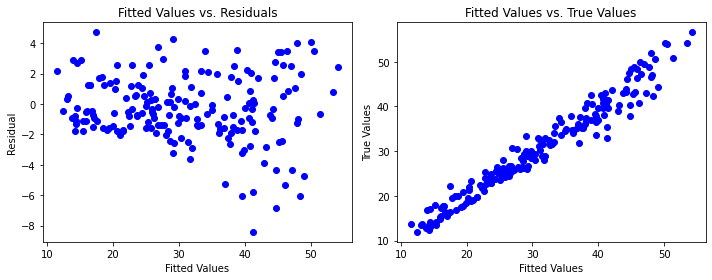

In [33]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total')
lm = LinearRegression()
lm = gmp.run_model(X_train, X_val, y_train, y_val, lm, diagnostics = True)

This model gave a Test MSE of 4.9234 and R^2 value of 0.95703, so this is a very good model.

### Model 2: Ridge Regression

Next, we look at Ridge regression. To begin, we find an optimal value of alpha, a hyperparameter, in order to decrease model variance. 

In [5]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total', standardize_cols = mylist[1:7].tolist())
                                                   #['input_footprint_transportation_num_vehicles', 'input_footprint_transportation_miles1', 'airflights', 'input_footprint_housing_electricity_dollars', 'input_footprint_housing_squarefeet', 'input_footprint_shopping_goods_clothing'])

alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gmp.linreg_kfold_cv(RidgeCV, X_train, X_val, y_train, y_val, alphas)

Standardizing data...
Splitting data...
optimal alpha: 0.0
Test MSE with cross-validated RidgeCV: 4.92344121392362
[R^2: 0.957026275754538]


0.0

This gave an optimal alpha value of 0. We will zoom in around that value to see if there is an even optimal value of alpha and then see the new test MSE and R^2 value. However as the alpha value is so small, we expect that the coefficients will be almost the same as the results from linear regression. 

In [19]:
new_alphas = np.arange(0,0.0001,0.00001)
gmp.linreg_kfold_cv(RidgeCV, X_train, X_val, y_train, y_val, new_alphas)
new_alphas

optimal alpha: 6.000000000000001e-05
Test MSE with cross-validated RidgeCV: 4.926218463353111
[R^2: 0.9570020348332071]


array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05,
       8.e-05, 9.e-05])

Fitting Model...
[Train MSE: 3.8853]
[Train R^2: 0.9666381731710392]
[Test MSE: 4.9262]
[Test R^2: 0.9570020348332071]
----FINISHED----


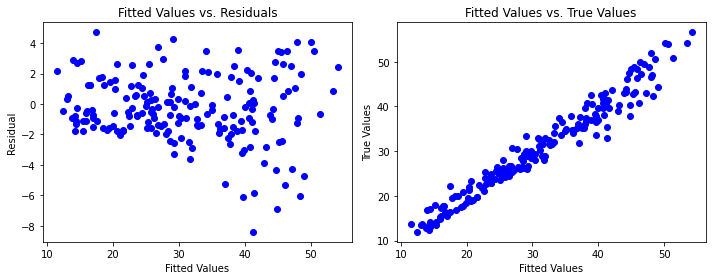

In [20]:
ridge_model = Ridge(alpha=6.e-05)
ridge_model = gmp.run_model(X_train, X_val, y_train, y_val, ridge_model, diagnostics=True)

The test MSE and R^2 values stayed around the same at MSE: 4.9262 and R^2: 0.957 (compared to the test MSE of 4.9234 and R^2 value of 0.95703 in the linear model). This shows that undergoing a ridge regression model did not show that much of an improvement.

### Model 3: Lasso Regression

Next, we move on to Lasso Regression. As Ridge regression did not do much better than linear, we do not expect Lasso do perform much better as well. 

In [21]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total', standardize_cols = mylist[1:7].tolist())
alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gmp.linreg_kfold_cv(LassoCV, X_train, X_val, y_train, y_val, alphas)

Standardizing data...
Splitting data...
optimal alpha: 0.0
Test MSE with cross-validated LassoCV: 4.923441213923627
[R^2: 0.9570262757545379]


C:\Users\miche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\miche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\miche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\miche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\miche\anaconda3\lib\site-packages\sklearn\linea

0.0

Again, the optimal alpha was 0. So as we zoom in around 0 to find an even optimal value, we will keep in mind that Lasso will perform the same as linear and ridge regression. 

In [23]:
new_alphas_lasso = np.arange(0,0.001,0.00001)
gmp.linreg_kfold_cv(LassoCV, X_train, X_val, y_train, y_val, new_alphas_lasso)

optimal alpha: 1e-05
Test MSE with cross-validated LassoCV: 4.924770408176923
[R^2: 0.9570146740262289]


C:\Users\miche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\miche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\miche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\miche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1221.3274928599276, tolerance: 6.889360602291819
  model = cd_fast.enet_coordinate_des

1e-05

Standardizing data...
Splitting data...
Fitting Model...
[Train MSE: 3.8852]
[Train R^2: 0.9666390306371127]
[Test MSE: 4.9248]
[Test R^2: 0.9570146740262289]
----FINISHED----


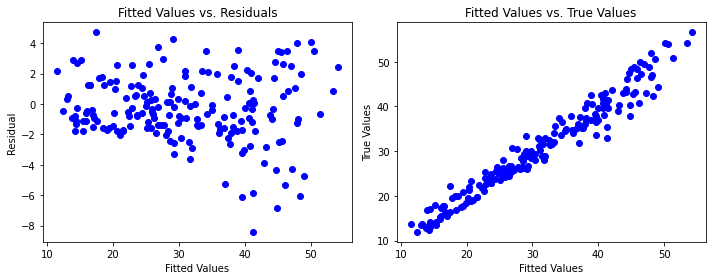

In [29]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total', standardize_cols =  mylist[1:7].tolist())

lasso_model = Lasso(alpha=1.e-05)
lasso_model = gmp.run_model(X_train, X_val, y_train, y_val, lasso_model, diagnostics=True)

Using Lasso regression, the test MSE was 4.9248 and R^2 value of 0.957 so this model performed the same as the other two. 

## Model 4: Decision Tree

Finally, we will move on to decision trees. As the linear model performed so well, we expect that decision tree model will not work as well as it uses a non-linear mapping. 

In [60]:
param_dist = {'max_leaf_nodes': np.arange(2, 20),
              'max_features': np.arange(2, 8),
              'max_depth': np.arange(2,10)}

tree = DecisionTreeRegressor(random_state = 100, max_depth = 4, max_features=5, max_leaf_nodes=10)
gmp.tree_kfold_cv(tree, param_dist, X_train, y_train, n_iter=1000, random_state = 100)

C:\Users\miche\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 864 is smaller than n_iter=1000. Running 864 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.9038011675774908
{'max_leaf_nodes': 19, 'max_features': 7, 'max_depth': 5}


Splitting data...
Fitting Model...
[Train MSE: 7.6163]
[Train R^2: 0.9323808889115687]
[Test MSE: 8.6573]
[Test R^2: 0.9281787563258698]
----FINISHED----


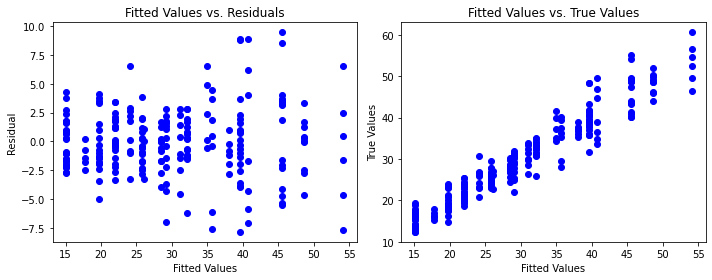

In [61]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(df, 'result_grand_total', standardize_cols = [None])

tree_model = DecisionTreeRegressor(random_state=100, max_leaf_nodes = 19,
                                   max_depth=6, max_features = 8)
tree_model = gmp.run_model(X_train, X_val, y_train, y_val, tree_model, diagnostics=True)

As expected, using a decision tree model performed the worst out of all of the model above as it had the highest test MSE of 8.6573 and lowest R^2 value o 0.928. In addition, the fitted values had a high variance.

## Comparison on Test Set

In [64]:
X_test = test_data.drop(columns='result_grand_total')
y_test = test_data['result_grand_total']
test_data
X_train.shape


(934, 8)

In [66]:
lr_test_preds = lm.predict(X_test)
ridge_test_preds = ridge_model.predict(X_test)
lasso_test_preds = lasso_model.predict(X_test)
#tree_test_preds = tree_model.predict(X_test)


{'Linear Regression' : mean_squared_error(lr_test_preds, y_test),
 'Ridge Regression' : mean_squared_error(ridge_test_preds, y_test),
 'Lasso Regression' : mean_squared_error(lasso_test_preds, y_test)}
 #'Decision Forest' : mean_squared_error(tree_test_preds, y_test)}

{'Linear Regression': 4.925913086620728,
 'Ridge Regression': 23050740494365.4,
 'Lasso Regression': 23152365156712.074}

## Interpretation and Conclusions (20 points)
In this section you must relate your modeling and forecasting results to your original prediction question.  You must:
1. Address a resource allocation question.  What do the answers mean? What advice would you give a decision maker on the basis of your results?  How might they allocate their resources differently with the results of your model?  Why should the reader care about your results?
2. Discuss caveats and / or reasons your results might be flawed.  No model is perfect, and understanding a model's imperfections is extremely important for the purpose of knowing how to interpret your results.  Often, we know the model output is wrong but we can assign a direction for its bias.  This helps to understand whether or not your answers are conservative.  

Shoot for 500-1000 words for this section.

Since the goal of this prediction problem was to make a model where every feature played an important part in predicting the total carbon output, it seems that a simple linear model sufficed for this question. As my Lasso, Ridge, and linear regression models all had a very similar MSE and R^2 value, the linear model seemed just as good as Lasso and ridge. In addition, when searching for the optimum alpha values for both Ridge and Lasso, both were very small, (10^-6) which made the coefficients of both models close to the linear regression model 